<strong> Import all libraires that will be used </strong>

In [1]:
from utils import PaintingsDataset, AttentionUNetDiscriminator, AttentionUNetGenerator, unet_d_criterion_without_cutmix
import os
import random
import torch
from torch.utils.data import DataLoader
from torchmetrics.image.fid import FrechetInceptionDistance
import torch.optim as optim
from torchvision import transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import math

<strong> Initializing the paintings dataset </strong>

In [2]:
# Building the dataset
image_dir = '../../data/anime/images'

f = os.listdir(image_dir)[0]
print(f)
print(os.path.isfile(os.path.join(image_dir, f)))

# Transformations to normalize the data before dataloader
transform = transforms.Compose([
    transforms.Resize((64,64)), # Standardizing the size of the images
    transforms.ToTensor(), # Transforming to tensor
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) # Normalizing
])


# Initializing the dataset
paintings = PaintingsDataset(image_dir, transform, limit=5000)
print(f"Dataset contains {len(paintings)} images")

0_2000.jpg
True
Dataset contains 5000 images


<strong> Sampling an element from the dataset and plotting it </strong>

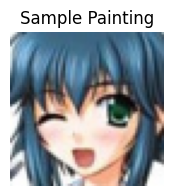

In [3]:
# Sampling randomly an element from the dataset
n = len(paintings)
integer = random.randint(0,n)

# Sampled image
image = paintings[integer].numpy()*0.5 + 0.5 # De-normalizing the image

# Plot the image
plt.figure(figsize=(3, 2))
plt.imshow(np.transpose(image, (1, 2, 0)))  
plt.axis('off')  # Hide axes
plt.title('Sample Painting')
plt.show()

<strong> Intializing the Dataloader </strong>

In [4]:
dataloader = DataLoader(paintings, batch_size=128)

<strong> Initializing the parameters of the model </strong>

In [5]:
# Model's parameters
latent_dim = 100
channels_out = 3
channels_in = 3

# Intializing the models
G = AttentionUNetGenerator(latent_dim, channels_out)
D = AttentionUNetDiscriminator(3)

<strong> Sampling a vector to plot the fake image generated by the Generator </strong>

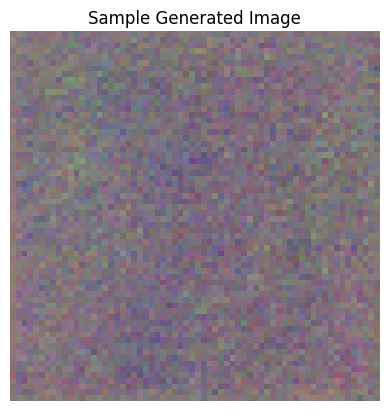

In [6]:
# Generate random noise
latent_dim = 100  # Latent space dimension

# Generate random noise
noise = torch.randn(16, latent_dim, 64, 64)  # Noise input for generator
# Generate images
fake_images = G(noise)  # Output shape: [16, 3, 128, 128]

# De-normalize and reshape the first generated image
image_generated = fake_images[0].detach().cpu().numpy()  # Select first image in batch
image_generated = image_generated * 0.5 + 0.5  # De-normalize to [0, 1]

# Plot the image
plt.imshow(np.transpose(image_generated, (1, 2, 0)))  # Convert to (H, W, C)
plt.axis('off')  # Hide axes
plt.title('Sample Generated Image')
plt.show()

<strong> Let build the training loop</strong>

In [7]:
import torch.nn.functional as F
from torchvision.models import resnet18, ResNet18_Weights

def diversity_loss(fake_images, feature_extractor):
    # Extract features using a pretrained model
    features = feature_extractor(fake_images)  # Shape: (batch_size, feature_dim)

    # Normalize features to unit vectors
    features = F.normalize(features, p=2, dim=1)

    # Compute pairwise cosine similarity
    similarity_matrix = torch.matmul(features, features.T)  # Shape: (batch_size, batch_size)

    # Remove diagonal elements (self-similarity)
    batch_size = similarity_matrix.size(0)
    mask = torch.eye(batch_size, device=similarity_matrix.device).bool()
    diversity_penalty = similarity_matrix.masked_fill(mask, 0).mean()

    return diversity_penalty

In [8]:

torch.autograd.set_detect_anomaly(True)

loss_options = ["w","bce"]
loss_option = loss_options[0]

experiment = 2

output_dir = f"training_samples/experiment_{experiment}"
os.makedirs(output_dir, exist_ok=True)

# Parameters
input_channels = 3
channels_out = input_channels
n_classes = 2
k = 5  # Steps to train generator
latent_dim = 128
epochs = 5000 # Total number of epochs
lambda_gp = 10  # Gradient penalty weight
lambda_div = 10  # Diversity loss weightv

d_lr = 2e-6 if loss_option == "w" else 2e-4  # Base learning rate
g_lr = 1e-5 if loss_option == "w" else 2e-4  # Base learning rate


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# feature extractor to compute diversity loss
feature_extractor = resnet18(weights=ResNet18_Weights.DEFAULT)
feature_extractor.eval().to(device)

# Initialize models (Use Attention U-Net GAN models)
G_attention = AttentionUNetGenerator(latent_dim, channels_out).to(device)  # Latent space maps to input

if loss_option == "w":
    D_attention = AttentionUNetDiscriminator(input_channels, features=64, use_sigmoid=False).to(device)  # Wasserstein discriminator
elif loss_option == "bce":
    D_attention = AttentionUNetDiscriminator(input_channels, features=64).to(device)  # PatchGAN discriminator

# Loss function and optimizers
if loss_option == "bce":
    criterion = torch.nn.BCELoss()  # Binary Cross-Entropy for GANs

optimizer_g = torch.optim.Adam(G_attention.parameters(), lr=g_lr, betas=(0.0, 0.9) if loss_option == "w" else (0.5, 0.999))
optimizer_d = torch.optim.Adam(D_attention.parameters(), lr=d_lr, betas=(0.0, 0.9) if loss_option == "w" else (0.5, 0.999))

# FID Evaluation setup
epoch_eval = epochs // 20  # Evaluate FID every `epoch_eval` epochs
epoch_sampling = 10 # Save generated samples every `epoch_sampling` epochs

fid = FrechetInceptionDistance(feature=192, reset_real_features=False, normalize=True)
n_samples = 500

# Ensure your dataset of real paintings is available
N = len(paintings)  # Assuming `paintings` is a tensor of real images
indices = random.sample(range(N), n_samples)
real_images_eval = torch.stack([paintings[idx] for idx in indices])
fid.update(real_images_eval, real=True)

# Track losses and FID values
FID_values = []
D_loss = []
G_loss = []

for epoch in tqdm(range(epochs)):
    train_gen = True if epoch % k == 0 else False  # Train generator every `k` steps
    
    start_time = time.time()

    for batch in tqdm(dataloader):
        # Get real images
        real_images = batch.to(device)
        batch_size = real_images.size(0)

        # Labels for real and fake images
        if loss_option == "bce":
            labels_real = torch.full((batch_size, 1), 0.9, device=device)
            labels_fake = torch.full((batch_size, 1), 0.1, device=device)

        ### Train Discriminator ###
        D_attention.zero_grad()
        
        # Real images
        real_images = real_images + torch.randn_like(real_images) * 0.01
        if loss_option == "w":
            output_real = D_attention(real_images).view(-1)
            loss_d_real = -output_real.mean()
        elif loss_option == "bce":
            output_real = D_attention(real_images).view(-1, 1)
            loss_d_real = criterion(output_real, labels_real)

        # Fake images
        noise = torch.randn(batch_size, latent_dim, 64, 64, device=device)
        fake_images = G_attention(noise) # Generate fake images, keep gradients for generator update
                
        fake_images = fake_images + torch.randn_like(fake_images) * 0.01
        if loss_option == "w":
            output_fake = D_attention(fake_images.detach()).view(-1)
            loss_d_fake = output_fake.mean()
        elif loss_option == "bce":
            output_fake = D_attention(fake_images.detach()).view(-1, 1)
            loss_d_fake = criterion(output_fake, labels_fake)
        
        alpha = torch.rand(batch_size, 1, 1, 1, device=device)  # Random weight for interpolation
        interpolates = alpha * real_images + (1 - alpha) * fake_images.detach()
        interpolates.requires_grad_(True)  # Enable gradients for interpolated images

        d_out_interpolates = D_attention(interpolates).view(-1)
        gradients = torch.autograd.grad(
            outputs=d_out_interpolates,
            inputs=interpolates,
            grad_outputs=torch.ones_like(d_out_interpolates),
            create_graph=True,
            retain_graph=True,
        )[0]  # Get gradients of interpolated images

        # Compute gradient penalty
        gradients_norm = gradients.norm(2, dim=1)
        gradient_penalty = ((gradients_norm - 1) ** 2).mean()
        

        # Combine losses
        loss_d = loss_d_real + loss_d_fake + lambda_gp * gradient_penalty
        
        loss_d.backward()
        optimizer_d.step()

        ### Train Generator ###
        if train_gen:  # Train generator every `k` steps
            for p in D_attention.parameters():
                p.requires_grad = False # Avoid computing gradients for discriminator
            
            G_attention.zero_grad()
            if loss_option == "w":
                output_fake_for_gen = D_attention(fake_images).view(-1)
                loss_g = -output_fake_for_gen.mean()
            elif loss_option == "bce":        
                output_fake_for_gen = D_attention(fake_images).view(-1, 1)
                loss_g = criterion(output_fake_for_gen, labels_real)  # Generator tries to make fake images appear real
                
            diversity_penalty = diversity_loss(fake_images, feature_extractor)
            loss_g += lambda_div * diversity_penalty
            loss_g.backward()
            optimizer_g.step()
            
            for p in D_attention.parameters():
                p.requires_grad = True # Restore gradient computation for discriminator
            
    
    # Evaluate FID every `epoch_eval` epochs
    if epoch % epoch_eval == 0:
        G_attention.eval()  # Set generator to eval mode for FID computation
        fake_images_eval = []
        with torch.no_grad():
        # Generate evaluation images
            noise_eval = torch.randn(n_samples, latent_dim, 64, 64, device=device)
            for i in range(0, n_samples, batch_size):
                fake_images_chunk = G_attention(noise_eval[i:i+batch_size]).to('cpu')
                fid.update(fake_images_chunk, real=False)
                fake_images_eval.append(fake_images_chunk)

            fid_value = fid.compute().item()
            FID_values.append(fid_value)

            print(f'FID after epoch {epoch}: {fid_value}')

        # Save a grid of generated samples
        fake_images_eval = torch.cat(fake_images_eval, dim=0)
        grid = vutils.make_grid(fake_images_eval[:64], normalize=True, scale_each=True)
        sample_path = os.path.join(output_dir, f"epoch_{epoch:03d}.png")
        vutils.save_image(grid, sample_path)
        print(f"Sample images saved to {sample_path}")
        
        del fake_images_eval
        torch.cuda.empty_cache()
        fid.reset()
        G_attention.train()
        
    elif epoch % epoch_sampling == 0:
        G_attention.eval()  # Set generator to eval mode for FID computation
        
        # Generate evaluation images
        with torch.no_grad():
            noise_eval = torch.randn(64, latent_dim, 64, 64, device=device)
            fake_images_eval = G_attention(noise_eval).to(torch.device('cpu'))
        
        # Save a grid of generated samples
        grid = vutils.make_grid(fake_images_eval, normalize=True, scale_each=True)
        sample_path = os.path.join(output_dir, f"epoch_{epoch:03d}.png")
        vutils.save_image(grid, sample_path)
        print(f"Sample images saved to {sample_path}")
        
        del fake_images_eval
        torch.cuda.empty_cache()
        G_attention.train()
        
        # Track losses
        D_loss.append(loss_d.item())
        G_loss.append(loss_g.item())

    end_time = time.time()
    if train_gen:
        print(f'Epoch [{epoch + 1}/{epochs}] | Loss D: {loss_d.item()} | Loss G: {loss_g.item()} | Diversity Loss: {lambda_div*diversity_penalty.item()} | Gradient Penalty: {lambda_gp*gradient_penalty.item()} | Wasserstein Distance: { - loss_d_real.item() - loss_d_fake.item()}')
    else :
        print(f'Epoch [{epoch + 1}/{epochs}] | Loss D: {loss_d.item()} | Gradient Penalty: {lambda_gp*gradient_penalty.item()} | Wasserstein Distance: { - loss_d_real.item() - loss_d_fake.item()}')
    print(f'Epoch duration: {end_time - start_time:.2f}s')


cuda


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

FID after epoch 0: 255.8490447998047
Sample images saved to training_samples/experiment_2\epoch_000.png
Epoch [1/5000] | Loss D: 9.81712532043457 | Loss G: 4.270605564117432 | Diversity Loss: 4.296432137489319 | Gradient Penalty: 9.986772537231445 | Wasserstein Distance: 0.1696471106261015
Epoch duration: 36.40s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [2/5000] | Loss D: 9.550535202026367 | Gradient Penalty: 9.984814524650574 | Wasserstein Distance: 0.4342798925936222
Epoch duration: 16.54s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [3/5000] | Loss D: 9.164795875549316 | Gradient Penalty: 9.98225450515747 | Wasserstein Distance: 0.8174578696489334
Epoch duration: 16.90s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [4/5000] | Loss D: 8.637567520141602 | Gradient Penalty: 9.979478120803833 | Wasserstein Distance: 1.3419101536273956
Epoch duration: 16.74s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [5/5000] | Loss D: 7.933865070343018 | Gradient Penalty: 9.975448846817017 | Wasserstein Distance: 2.041583463549614
Epoch duration: 17.12s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [6/5000] | Loss D: 7.366724014282227 | Loss G: 4.2782111167907715 | Diversity Loss: 4.816722869873047 | Gradient Penalty: 9.970320463180542 | Wasserstein Distance: 2.6035969257354736
Epoch duration: 94.52s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [7/5000] | Loss D: 6.2865214347839355 | Gradient Penalty: 9.963846206665039 | Wasserstein Distance: 3.6773247718811035
Epoch duration: 16.72s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [8/5000] | Loss D: 5.131789207458496 | Gradient Penalty: 9.957172274589539 | Wasserstein Distance: 4.825383245944977
Epoch duration: 17.13s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [9/5000] | Loss D: 3.5944652557373047 | Gradient Penalty: 9.946286678314209 | Wasserstein Distance: 6.351821660995483
Epoch duration: 16.47s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [10/5000] | Loss D: 1.9293947219848633 | Gradient Penalty: 9.936352968215942 | Wasserstein Distance: 8.006958246231079
Epoch duration: 17.50s


  0%|          | 0/40 [00:00<?, ?it/s]

Sample images saved to training_samples/experiment_2\epoch_010.png
Epoch [11/5000] | Loss D: 5.7665934562683105 | Loss G: -2.9778804779052734 | Diversity Loss: 4.195283949375153 | Gradient Penalty: 9.924668669700623 | Wasserstein Distance: 4.158074855804443
Epoch duration: 89.38s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [12/5000] | Loss D: 4.893693447113037 | Gradient Penalty: 9.918233752250671 | Wasserstein Distance: 5.024540424346924
Epoch duration: 13.68s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [13/5000] | Loss D: 3.9780921936035156 | Gradient Penalty: 9.908422827720642 | Wasserstein Distance: 5.930330276489258
Epoch duration: 13.75s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [14/5000] | Loss D: 3.0831737518310547 | Gradient Penalty: 9.899324774742126 | Wasserstein Distance: 6.816150665283203
Epoch duration: 13.69s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [15/5000] | Loss D: 1.8201398849487305 | Gradient Penalty: 9.89043116569519 | Wasserstein Distance: 8.070291519165039
Epoch duration: 13.84s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [16/5000] | Loss D: 8.445765495300293 | Loss G: -10.962396621704102 | Diversity Loss: 4.585195183753967 | Gradient Penalty: 9.899243116378784 | Wasserstein Distance: 1.4534778594970703
Epoch duration: 25.52s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [17/5000] | Loss D: 7.2159013748168945 | Gradient Penalty: 9.906744956970215 | Wasserstein Distance: 2.6908435821533203
Epoch duration: 13.99s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [18/5000] | Loss D: 6.102182388305664 | Gradient Penalty: 9.911488890647888 | Wasserstein Distance: 3.8093061447143555
Epoch duration: 22.49s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [19/5000] | Loss D: 5.106654167175293 | Gradient Penalty: 9.912174940109253 | Wasserstein Distance: 4.805521011352539
Epoch duration: 22.76s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [20/5000] | Loss D: 3.9557738304138184 | Gradient Penalty: 9.913461208343506 | Wasserstein Distance: 5.957687854766846
Epoch duration: 28.71s


  0%|          | 0/40 [00:00<?, ?it/s]

Sample images saved to training_samples/experiment_2\epoch_020.png
Epoch [21/5000] | Loss D: 3.574841022491455 | Loss G: -2.1566081047058105 | Diversity Loss: 4.464707374572754 | Gradient Penalty: 9.910245537757874 | Wasserstein Distance: 6.335404872894287
Epoch duration: 31.34s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [22/5000] | Loss D: 2.2393202781677246 | Gradient Penalty: 9.910995960235596 | Wasserstein Distance: 7.671675205230713
Epoch duration: 14.12s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [23/5000] | Loss D: 0.9152984619140625 | Gradient Penalty: 9.904069900512695 | Wasserstein Distance: 8.988771915435791
Epoch duration: 13.78s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [24/5000] | Loss D: -0.5135622024536133 | Gradient Penalty: 9.884737730026245 | Wasserstein Distance: 10.398300409317017
Epoch duration: 13.85s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [25/5000] | Loss D: -1.5877666473388672 | Gradient Penalty: 9.906759262084961 | Wasserstein Distance: 11.494525909423828
Epoch duration: 13.79s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [26/5000] | Loss D: 1.0206108093261719 | Loss G: -2.880277633666992 | Diversity Loss: 2.9927533864974976 | Gradient Penalty: 9.861100912094116 | Wasserstein Distance: 8.840490818023682
Epoch duration: 26.06s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [27/5000] | Loss D: -0.016409873962402344 | Gradient Penalty: 9.843158721923828 | Wasserstein Distance: 9.85956859588623
Epoch duration: 13.95s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [28/5000] | Loss D: -1.2529926300048828 | Gradient Penalty: 9.864614009857178 | Wasserstein Distance: 11.117607116699219
Epoch duration: 14.07s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [29/5000] | Loss D: -2.74649715423584 | Gradient Penalty: 9.851938486099243 | Wasserstein Distance: 12.598435401916504
Epoch duration: 13.78s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [30/5000] | Loss D: -3.732389450073242 | Gradient Penalty: 9.843891859054565 | Wasserstein Distance: 13.576281785964966
Epoch duration: 13.86s


  0%|          | 0/40 [00:00<?, ?it/s]

Sample images saved to training_samples/experiment_2\epoch_030.png
Epoch [31/5000] | Loss D: 11.931516647338867 | Loss G: -18.150455474853516 | Diversity Loss: 2.9236820340156555 | Gradient Penalty: 9.791637063026428 | Wasserstein Distance: -2.1398792266845703
Epoch duration: 27.44s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [32/5000] | Loss D: 9.439648628234863 | Gradient Penalty: 9.773815870285034 | Wasserstein Distance: 0.33416748046875
Epoch duration: 13.77s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [33/5000] | Loss D: 6.342107772827148 | Gradient Penalty: 9.786552786827087 | Wasserstein Distance: 3.4444446563720703
Epoch duration: 13.79s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [34/5000] | Loss D: 3.4951648712158203 | Gradient Penalty: 9.770616292953491 | Wasserstein Distance: 6.27545166015625
Epoch duration: 13.78s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [35/5000] | Loss D: 0.8734264373779297 | Gradient Penalty: 9.770391583442688 | Wasserstein Distance: 8.896965026855469
Epoch duration: 13.79s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [36/5000] | Loss D: 18.89468765258789 | Loss G: -35.152156829833984 | Diversity Loss: 3.4522974491119385 | Gradient Penalty: 9.784655570983887 | Wasserstein Distance: -9.110031127929688
Epoch duration: 48.47s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [37/5000] | Loss D: 14.858980178833008 | Gradient Penalty: 9.810991287231445 | Wasserstein Distance: -5.0479888916015625
Epoch duration: 13.82s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [38/5000] | Loss D: 11.371323585510254 | Gradient Penalty: 9.83707308769226 | Wasserstein Distance: -1.534250259399414
Epoch duration: 13.79s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [39/5000] | Loss D: 8.401843070983887 | Gradient Penalty: 9.84740138053894 | Wasserstein Distance: 1.4455585479736328
Epoch duration: 13.80s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [40/5000] | Loss D: 4.956232070922852 | Gradient Penalty: 9.845424890518188 | Wasserstein Distance: 4.889192581176758
Epoch duration: 13.83s


  0%|          | 0/40 [00:00<?, ?it/s]

Sample images saved to training_samples/experiment_2\epoch_040.png
Epoch [41/5000] | Loss D: 12.184944152832031 | Loss G: -24.92264175415039 | Diversity Loss: 2.0661693811416626 | Gradient Penalty: 9.854045510292053 | Wasserstein Distance: -2.3308982849121094
Epoch duration: 48.28s


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch [42/5000] | Loss D: 10.214184761047363 | Gradient Penalty: 9.87960696220398 | Wasserstein Distance: -0.3345775604248047
Epoch duration: 14.18s


  0%|          | 0/40 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [9]:
torch.save(D_attention.state_dict(), f"weights/d_att_{experiment}.pth")
torch.save(G_attention.state_dict(), f"weights/g_att_{experiment}.pth")

<strong> Generating some examples using the trained generator </strong>

torch.Size([1, 3, 64, 64])


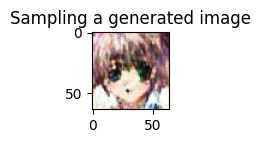

In [ ]:
# Generate random noise
noise = torch.randn(1, latent_dim, 64, 64)  # Batch of 16 noise vectors

G_unet_test = G_attention.to('cpu')
# Generate images
fake_images = G_unet_test(noise)

print(fake_images.size())  # Should be (16, img_channels, height, width)

image_noise = fake_images.detach().numpy().reshape((3,64,64))*0.5 + 0.5

plt.figure(figsize=(2, 1))
plt.imshow(np.transpose(image_noise, (1, 2, 0)))
plt.title("Sampling a generated image")
plt.show()

<strong> Plotting Losses <strong>

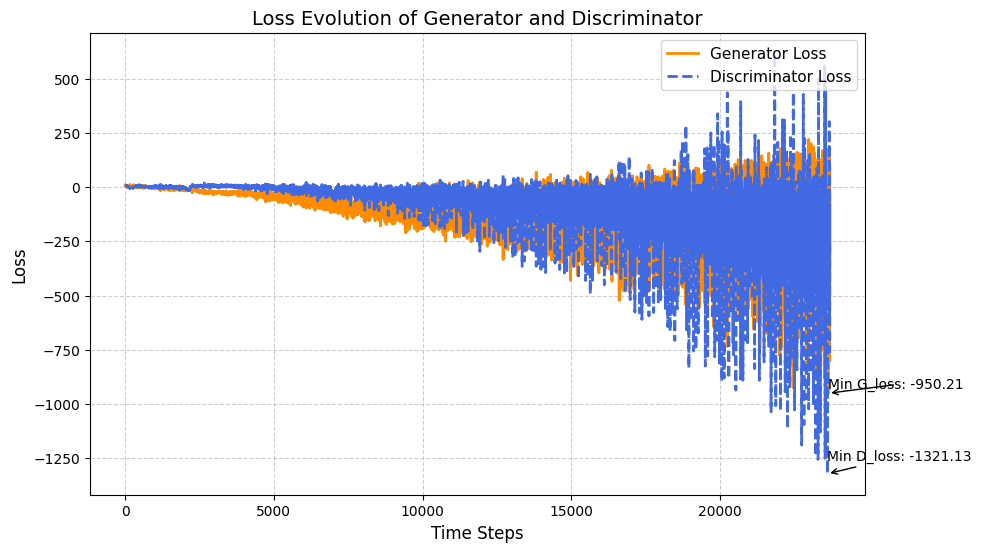

In [ ]:
# Assuming G_loss and D_loss are defined
ng = len(G_loss)
nd = len(D_loss)
time_steps_g = [i for i in range(ng)]
time_steps_d = [i for i in range(nd)]


plt.figure(figsize=(10, 6))

# Plot Generator Loss
plt.plot(time_steps_g, G_loss, label='Generator Loss', color='darkorange', linestyle='-', linewidth=2)

# Plot Discriminator Loss
plt.plot(time_steps_d, D_loss, label='Discriminator Loss', color='royalblue', linestyle='--', linewidth=2)

# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Loss Evolution of Generator and Discriminator', fontsize=14)

# Adding legend
plt.legend(loc='upper right', fontsize=11)

# Adding annotations for minimum loss points (optional)
min_G_loss = min(G_loss)
min_G_loss_idx = G_loss.index(min_G_loss)
plt.annotate(f'Min G_loss: {min_G_loss:.2f}', xy=(min_G_loss_idx, min_G_loss),
             xytext=(min_G_loss_idx + n*0.1, min_G_loss + max(G_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

min_D_loss = min(D_loss)
min_D_loss_idx = D_loss.index(min_D_loss)
plt.annotate(f'Min D_loss: {min_D_loss:.2f}', xy=(min_D_loss_idx, min_D_loss),
             xytext=(min_D_loss_idx + n*0.1, min_D_loss + max(D_loss)*0.1),
             arrowprops=dict(facecolor='black', arrowstyle='->'),
             fontsize=10)

# Show plot
plt.show()

<strong> Plotting FID values <strong>

Text(0.5, 1.0, 'FID Evolution through training')

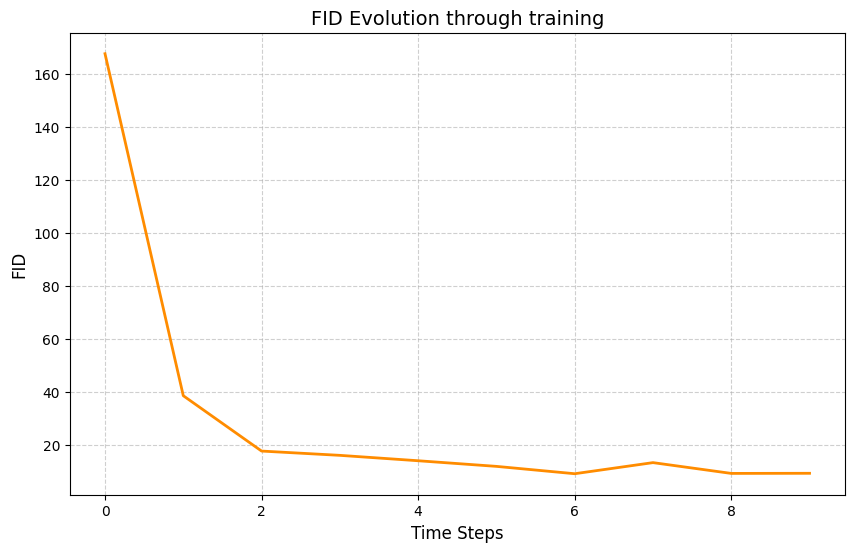

In [41]:
n = len(FID_values)
time_steps = [i for i in range(n)]

plt.figure(figsize=(10, 6))

# Plot FID values
plt.plot(time_steps, FID_values, label='Generator FID', color='darkorange', linestyle='-', linewidth=2)


# Add grid, labels, and title
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Time Steps', fontsize=12)
plt.ylabel('FID', fontsize=12)
plt.title('FID Evolution through training', fontsize=14)

In [57]:
# Save G_loss and D_loss to text files
np.savetxt(f'plots/g_loss_{experiment}.txt', np.array(G_loss))
np.savetxt(f'plots/d_loss_{experiment}.txt', np.array(D_loss))

# Load G_loss and D_loss from text files
loaded_g_loss = np.loadtxt(f'plots/g_loss_{experiment}.txt')
loaded_d_loss = np.loadtxt(f'plots/d_loss_{experiment}.txt')

In [56]:
# Save FID values to a text file
np.savetxt(f'plots/fid_values_{experiment}.txt', np.array(FID_values))

# Load FID values from a text file
loaded_fid_values = np.loadtxt(f'plots/fid_values_{experiment}.txt')
print(loaded_fid_values)

[167.5610199   38.44625473  17.5518322   15.93503094  13.8961153
  11.77238846   8.99717808  13.18709373   9.11441422   9.15879726]
